# 

Imports

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, DateType
from pyspark.ml import Pipeline
from pyspark.ml.feature import IDF, Tokenizer, StopWordsRemover, StringIndexer, CountVectorizer, NGram, VectorAssembler, ChiSqSelector
from pyspark.sql.functions import col, sum as spark_sum
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns



# Variables de contexte

In [2]:
spark= SparkSession.builder.config("spark.storage.memoryFraction", "0.6").appName('Twitter_NB').getOrCreate()

24/05/05 17:02:50 WARN Utils: Your hostname, sasamg-HP-Laptop-15s-eq2xxx resolves to a loopback address: 127.0.1.1; using 192.168.100.63 instead (on interface wlo1)
24/05/05 17:02:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/05 17:02:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
training_path = 'twitter_training.csv'

### we defined a StructType. This allows us when reading the CSV containing the data, to tell Spark to load the data according to the schema defined above.

In [4]:
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("game", StringType(), True),
    StructField("sentiment", StringType(), True),
    StructField("tweet", StringType(), True)
])

In [5]:
dataset = spark.read.csv(training_path, inferSchema=True, schema = schema)
dataset.printSchema()

root
 |-- id: integer (nullable = true)
 |-- game: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- tweet: string (nullable = true)



In [6]:
dataset.show()

+----+-----------+---------+--------------------+
|  id|       game|sentiment|               tweet|
+----+-----------+---------+--------------------+
|2401|Borderlands| Positive|im getting on bor...|
|2401|Borderlands| Positive|I am coming to th...|
|2401|Borderlands| Positive|im getting on bor...|
|2401|Borderlands| Positive|im coming on bord...|
|2401|Borderlands| Positive|im getting on bor...|
|2401|Borderlands| Positive|im getting into b...|
|2402|Borderlands| Positive|So I spent a few ...|
|2402|Borderlands| Positive|So I spent a coup...|
|2402|Borderlands| Positive|So I spent a few ...|
|2402|Borderlands| Positive|So I spent a few ...|
|2402|Borderlands| Positive|2010 So I spent a...|
|2402|Borderlands| Positive|                 was|
|2403|Borderlands|  Neutral|Rock-Hard La Varl...|
|2403|Borderlands|  Neutral|Rock-Hard La Varl...|
|2403|Borderlands|  Neutral|Rock-Hard La Varl...|
|2403|Borderlands|  Neutral|Rock-Hard La Vita...|
|2403|Borderlands|  Neutral|Live Rock - Hard ...|


In [7]:
dataset.describe().show()

24/05/05 17:02:59 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+---------------+----------+--------------------+
|summary|               id|           game| sentiment|               tweet|
+-------+-----------------+---------------+----------+--------------------+
|  count|            74682|          74682|     74682|               73996|
|   mean|6432.586165341046|           NULL|      NULL|                 3.2|
| stddev|3740.427870177445|           NULL|      NULL|   2.007130147392398|
|    min|                1|         Amazon|Irrelevant|                    |
|    max|            13200|johnson&johnson|  Positive|🧻 at Home Depot ...|
+-------+-----------------+---------------+----------+--------------------+



In [8]:
null_counts = dataset.select(*(spark_sum(col(c).isNull().cast("int")).alias(c) for c in dataset.columns))
null_counts.show()

+---+----+---------+-----+
| id|game|sentiment|tweet|
+---+----+---------+-----+
|  0|   0|        0|  686|
+---+----+---------+-----+



# Text Preprocessing

In [9]:
print("The training dataset contains {} samples.".format(dataset.count()))

The training dataset contains 74682 samples.


In [10]:
dataset = dataset.dropna(subset=["tweet"])

#### The 'tweet' column in our dataset is in string format. Therefore, we cannot directly use it for training. First, we need to tokenize it, which we achieve with a tokenizer. Then, we convert these words into vectors using HashingTF. In the notebook's later part, we will see that CountVectorizer is used instead of this method. These two are completely separate methods, and both can be used. By applying these methods, we prepare our 'text' column for training by applying IDF to it. Finally, we label the target column with StringIndexer and convert it to double.

    1. Tokinizer : text -> words
    2. HashingTF : filtered_words -> tf
    3. IDF : tf -> features
    


In [11]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
cv = CountVectorizer(inputCol="words", outputCol="TF")
idf = IDF(inputCol="TF", outputCol="features")

#### now we will convert these categorical Target (column = sentiment) into numerical indices. we will use StringIndexer for this purpose.
    4. IDF : StringIndexer : target -> label

In [12]:
label = StringIndexer(inputCol="sentiment", outputCol="label", handleInvalid="skip")
nb = NaiveBayes(featuresCol="features", labelCol="label")

### If we start with logistic regression, we can put all these pre-processing steps in a pipeline to make it easier to run.

In [13]:
pipeline = Pipeline(stages=[tokenizer, cv, idf, label, nb])

## Chargement du dataset et séparation train/test

In [14]:
train_set, test_set = dataset.randomSplit([0.8, 0.2], seed=42)

# Modeling
### Logistic Regression model¶

In [15]:
# pipeline_model = pipeline.fit(train_set)
# predictions = pipeline_model.transform(test_set)

In [16]:
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_weighted_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_weighted_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

In [17]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 0.5, 1.0]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_accuracy,
                          numFolds=3) 

cvModel = crossval.fit(train_set)
predictions = cvModel.transform(test_set)

24/05/05 17:03:06 WARN DAGScheduler: Broadcasting large task binary with size 1646.2 KiB
24/05/05 17:03:07 WARN DAGScheduler: Broadcasting large task binary with size 1634.5 KiB
24/05/05 17:03:08 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/05/05 17:03:10 WARN DAGScheduler: Broadcasting large task binary with size 1646.2 KiB
24/05/05 17:03:10 WARN DAGScheduler: Broadcasting large task binary with size 1634.5 KiB
24/05/05 17:03:11 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/05/05 17:03:13 WARN DAGScheduler: Broadcasting large task binary with size 1646.2 KiB
24/05/05 17:03:13 WARN DAGScheduler: Broadcasting large task binary with size 1634.5 KiB
24/05/05 17:03:13 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/05/05 17:03:15 WARN DAGScheduler: Broadcasting large task binary with size 1651.0 KiB
24/05/05 17:03:16 WARN DAGScheduler: Broadcasting large task binary with size 1639.3 KiB
24/05/05 17:03:17 WARN DAGSche

In [18]:
accuracy_lr = evaluator_accuracy.evaluate(predictions)
f1_score_lr = evaluator_f1.evaluate(predictions)
weighted_precision_lr = evaluator_weighted_precision.evaluate(predictions)
weighted_recall_lr = evaluator_weighted_recall.evaluate(predictions)

24/05/05 17:03:32 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/05/05 17:03:33 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/05/05 17:03:33 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/05/05 17:03:33 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


In [19]:
print("\n ********************************************** \n")
print("Accuracy:", accuracy_lr)
print("F1 Score:", f1_score_lr)
print("Weighted Precision:", weighted_precision_lr)
print("Weighted Recall:", weighted_recall_lr)
print("\n ********************************************** \n")


 ********************************************** 

Accuracy: 0.8411732531108984
F1 Score: 0.8410991709322988
Weighted Precision: 0.8429710973919331
Weighted Recall: 0.8411732531108984

 ********************************************** 



In [20]:
predictions.show()

+---+------+----------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
| id|  game| sentiment|               tweet|               words|                  TF|            features|label|       rawPrediction|         probability|prediction|
+---+------+----------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|  1|Amazon|  Negative|       @ amazon wtf.|   [@, amazon, wtf.]|(65463,[15,124,25...|(65463,[15,124,25...|  0.0|[-110.24755941067...|[0.99446696726428...|       0.0|
|  2|Amazon|  Negative|I am really disap...|[i, am, really, d...|(65463,[0,1,2,4,6...|(65463,[0,1,2,4,6...|  0.0|[-1636.3645081622...|[1.0,8.3202220426...|       0.0|
|  2|Amazon|  Negative|I'm really disapp...|[i'm, really, dis...|(65463,[0,1,2,4,6...|(65463,[0,1,2,4,6...|  0.0|[-1792.4193917056...|[1.0,2.0565107225...|       0.0

24/05/05 17:03:34 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


/home/sasamg/.local/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/05/05 17:03:34 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/05/05 17:03:35 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


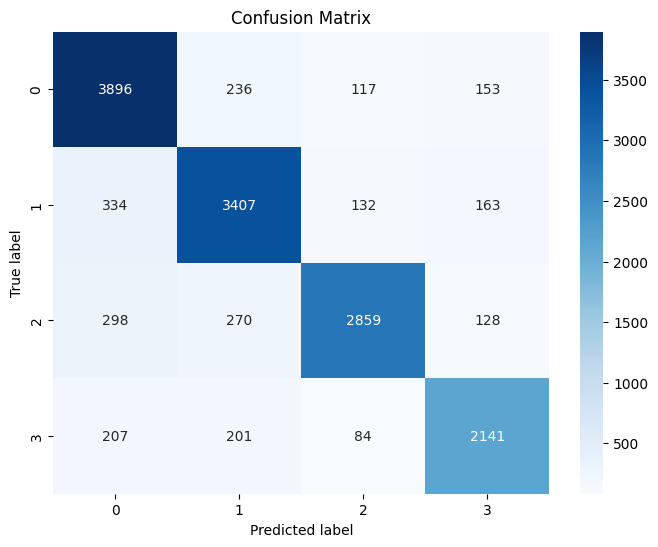

In [21]:
# Get predictions and labels as RDD
predictionAndLabels = predictions.select("prediction", "label").rdd

# Create MulticlassMetrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Compute confusion matrix
conf_matrix = metrics.confusionMatrix().toArray()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# cvModel.bestModel.save("naive_bayes_cv_model")

24/05/05 17:03:36 ERROR Instrumentation: java.io.IOException: Path naive_bayes_cv_model already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:174)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:169)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:42)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3$adapted(Pipeline.scala:344)


Py4JJavaError: An error occurred while calling o5546.save.
: java.io.IOException: Path naive_bayes_cv_model already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:174)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:169)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:42)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3$adapted(Pipeline.scala:344)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.save(Pipeline.scala:344)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
